# Partial wave analysis notebook
In the notebook I perform the mass-independent partial wave analysis in a single $m_{3\pi}$ bin.
 1. Prepare data: $M_{3\pi} \in [2.3, 2.31]\,$GeV
 2. Perpare Model: 88 waves, coherence $\text{FLAT}\otimes(\epsilon=+)\otimes(\epsilon=-)\otimes(\epsilon=-)$
 3. Perform fit: gradient based minimization in 186 dims

In [1]:
using JLD
using Plots

In [2]:
push!(LOAD_PATH,joinpath(pwd(),"src"))

3-element Array{Any,1}:
 "/home/mikhasenko/Tools/julia/usr/local/share/julia/site/v0.6"
 "/home/mikhasenko/Tools/julia/usr/share/julia/site/v0.6"      
 "/home/mikhasenko/Documents/pwa_from_scratch/src"             

In [3]:
# workspace()
using DalitzPlotAnalysis
using amplitudes_compass

## First step: data preparation

In [5]:
function precalculate_compass_basis(fin,fout)
    mm = readdlm(fin)#[1:1000,:];
    # fast code
    m2 = [COMPASS_wave(i,mm[e,:]...) for e=1:size(mm,1), i=1:88];
    # surprisingly filling array is slower
#     const m2 = Matrix{Complex{Float64}}(size(mm,1),88)
#     for e=1:size(mm,1), i=1:88
#         m2[e,i] = COMPASS_wave(i,mm[e,:]...)
#     end
    save(fout,"real",real(m2),"imag",imag(m2))
end
function read_precalc_basis(fname)
    ld = load(fname)
    ld["real"]+1im*ld["imag"]
end

read_precalc_basis (generic function with 1 method)

### Precalculate basis functions on Data events and MC events
The basis functions are some complex functions of kinematical variables $\tau = s,(\sigma_1,\Omega_1,\Omega_{23})$.

We calculate and save to the file the following matrix $N_\text{ev}\times 88$
$$
[\,\Psi_i(\tau_e)\,],\quad \forall i = 1,\dots,88,\quad e = 1,\dots,N_\text{ev}
$$

In [6]:
@time precalculate_compass_basis(joinpath(ENV["HOME"],"cernbox","tmp","pwa_from_scratch_data","2300.mc.txt"), "mc.jld")
# 355.232697 seconds (3.05 G allocations: 93.994 GiB, 3.26% gc time)

355.232697 seconds (3.05 G allocations: 93.994 GiB, 3.26% gc time)


In [7]:
@time precalculate_compass_basis(joinpath(ENV["HOME"],"cernbox","tmp","pwa_from_scratch_data","2300.rd.txt"), "rd.jld")
# 64.127467 seconds (581.89 M allocations: 17.920 GiB, 3.64% gc time)

 64.127467 seconds (581.89 M allocations: 17.920 GiB, 3.64% gc time)


In [8]:
const PsiMC = read_precalc_basis("mc.jld"); # [1:1000,:];

In [9]:
@time sum_mat = [sum(PsiMC[e,i]'*PsiMC[e,j] for e in 1:size(PsiMC,1)) for i=1:88, j=1:88]/size(PsiMC,1);
# 10.593515 seconds (101.00 k allocations: 4.752 MiB)

 10.593515 seconds (101.00 k allocations: 4.752 MiB)


In [14]:
sum_mat_n = [sum_mat[i,j]/sqrt(sum_mat[i,i]*sum_mat[j,j]) for i=1:88, j=1:88];

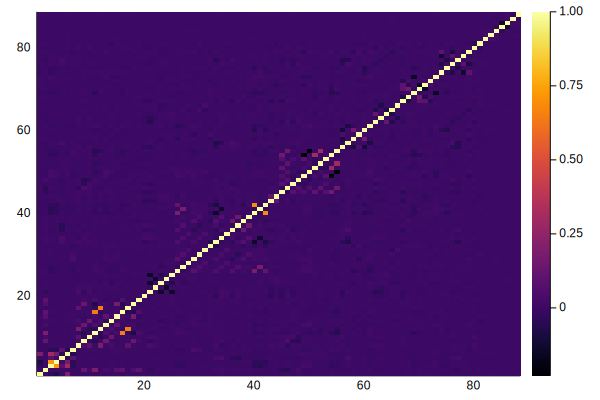

In [17]:
heatmap(real(sum_mat_n))

## Second step: Model preparation
Coherence matrix has block-diagonal form
$$
\begin{pmatrix}
\text{FLAT} && &\\
&\epsilon = + & &\\
& &\epsilon = - &\\
& & &\epsilon = -\\
\end{pmatrix}
$$

In [18]:
# waves = readdlm(pwd()*"/src/wavelist_formated.txt");
waves = readdlm(pwd()*"/src/wavelist_formated.txt");

In [19]:
const noϵ = [i==1 for i=1:size(waves[:,6],1)]
const posϵ = [ϵ=="+" for ϵ in waves[:,6]]
const negϵ = [ϵ=="-" for ϵ in waves[:,6]]
## decomp
sum(noϵ)+sum(posϵ)+sum(negϵ) == length(waves[:,6])
block(i) = 1*noϵ[i]+2*posϵ[i]+3*negϵ[i]

block (generic function with 1 method)

In [20]:
COH = [block(i)==block(j) for i=1:88, j=1:88];
const COHc = convert(Array{Complex{Float64},2},COH);

In [21]:
function COHsq(X::Vector{Complex{Float64}})
    sum(abs2(sum(X[bl])) for bl in [noϵ,posϵ,negϵ])
end
function COHts(X::Vector{Complex{Float64}})
    sum(sum(X[bl])*bl for bl in [noϵ,posϵ,negϵ])
end

COHts (generic function with 1 method)

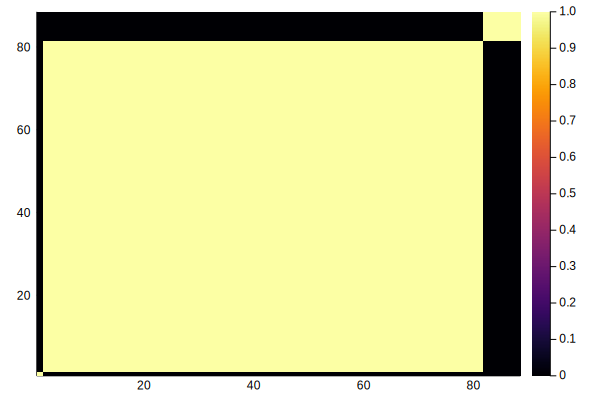

In [23]:
heatmap(COH)

### Map of parameters

In [24]:
const ModelBlocks = [noϵ,posϵ,negϵ,negϵ]
Trel = let vect=[]
    temp = []
    numb = []
    for bl in ModelBlocks
        push!(temp,false)
        push!(temp,[true for i=1:(sum(bl)-1)]...)
        push!(numb,collect(1:88)[bl]...)
    end 
    Trel = zeros(Complex{Float64},88,sum(temp+1))
    global Tmap = fill(0,2,sum(temp+1))
    count=1
    for (i,b) in enumerate(temp)
        Trel[numb[i],count] = 1.0;
        Tmap[1,count] = numb[i]
        count+=1
        if b
            Trel[numb[i],count] = 1.0im;
            Tmap[2,count] = numb[i];
            count+=1
        end
    end
    Trel
#     numb
end;

In [25]:
Tmap

2×186 Array{Int64,2}:
 1  2  3  0  4  0  5  0  6  0  7  0  8  …   0  85   0  86   0  87   0  88   0
 0  0  0  3  0  4  0  5  0  6  0  7  0     84   0  85   0  86   0  87   0  88

In [26]:
const TT = Trel;
const TM = Tmap;

In [27]:
function TTm(p)
    c = fill(0.0+0.0im,88)
    for i in 1:size(TM,2)
        TM[1,i]!=0 && (c[TM[1,i]]+=1.0*p[i])
        TM[2,i]!=0 && (c[TM[2,i]]+=1.0im*p[i])
    end
    c
end

TTm (generic function with 1 method)

In [30]:
const Bmat = sum_mat;
@time const TBmatT = real(TT'*(Bmat.*COHc)*TT);

  2.440466 seconds (1.29 M allocations: 63.842 MiB, 1.08% gc time)


### Real data

In [32]:
const BF = read_precalc_basis("rd.jld")#[1:10000,:]
const Nd = size(BF,1);

In [33]:
function get_form(B)
    m = B.*TT;
    v = m'COHc*m
    v
end

get_form (generic function with 1 method)

Likelihood functions

In [38]:
function LLH(pars::Vector{Float64})
    res = sum(log(real(begin
#                     m = get_form(BF[e,:])
                    cv = BF[e,:].*(TTm(pars))
                    COHsq(cv)
                    end)) for e in 1:Nd)
    - res + real(pars'*TBmatT*pars) * Nd
end
function getDv(psi::Vector{Complex{Float64}}, pars::Vector{Float64})
    cv = psi.*(TTm(pars))
    cvv = COHts(psi.*(TTm(pars)))
    v = [(TM[1,i] == 0 ? 0.0im : cvv[TM[1,i]]*psi[TM[1,i]]') - 1.0im*
         (TM[2,i] == 0 ? 0.0im : cvv[TM[2,i]]*psi[TM[2,i]]') for i in 1:size(TM,2)]
    return real(v)
end
function dLLH(pars::Vector{Float64})
    resP = sum(2real(begin
                    v = getDv(BF[e,:],pars)
                    v / (pars'*v)
                end)  for e in 1:Nd)
    - resP + 2real(TBmatT*pars)* Nd 
end
function LLH_and_GRAD!(pars::Vector{Float64}, grad::Vector{Float64})
    val = 0.0; grad .= 0.0
    for e in 1:Nd
        v = getDv(BF[e,:],pars)
        vale = pars'*v
        grad .-= v / vale
        val -= log(vale);
    end
    grad .*= 2.0
    # println(val)
    BB = TBmatT*pars;
    val += pars'*BB * Nd;
    grad .+= BB* (2Nd);
    return val;
end

LLH_and_GRAD! (generic function with 1 method)

In [39]:
test_t = rand(size(TT,2));

In [41]:
@time LLH(test_t)
@time dLLH(test_t)
@time g1 = let gra = Vector{Float64}(186)
    v = LLH_and_GRAD!(test_t,gra)
    @show v
    gra
end
# @time g2 = let gra = Vector{Float64}(186)
#     v = LLH_and_GRAD!(test_t,gra)
#     @show v
#     gra
# end
# max((g1-g2)...)

  0.326005 seconds (1.56 M allocations: 507.943 MiB, 20.07% gc time)
  1.004940 seconds (2.55 M allocations: 2.036 GiB, 17.65% gc time)
v = 3.0181079125718746e7
  0.955596 seconds (2.38 M allocations: 1.786 GiB, 18.19% gc time)


186-element Array{Float64,1}:
      1.3451e5 
      2.22443e6
      1.70511e5
      5.30061e5
      2.34699e5
 883170.0      
      2.85535e6
      1.30136e6
 -78631.4      
      1.09346e5
  44086.4      
  -3316.23     
      2.2488e6 
      ⋮        
      3.61065e6
      3.00268e6
      2.79054e6
      2.21624e6
      4.01044e6
      3.09014e6
 -26320.2      
 -31435.0      
  42163.5      
  57047.8      
  43903.8      
  49227.0      

In [42]:
using NLopt

In [43]:
function minimize(; verbose::Int=0, startpars::Vector{Float64} = rand(size(TT,2)))
#     function abs_inverse(x::Vector, grad::Vector) 
#         v = LLH(x)
#         if length(grad) > 0
#             grad[:] = dLLH(x)
#         end        
#         verbose==1 && println(v)
#         verbose==2 && println("\n------\n$x\n$grad\n->$v")
#         v
#     end
    function abs_inverse(x::Vector, grad::Vector) 
        if length(grad) > 0
            v = LLH_and_GRAD!(x,grad)
        else
            v = LLH(x)
        end
        verbose==1 && @show v
        verbose==2 && @show v,x
        verbose==3 && @show v,grad
        return v;
    end

    # find minimum which of course suppose t o be zero
#     opt = Opt(:LN_COBYLA, 88)
    opt = Opt(:LD_LBFGS, size(TT,2)) # try LD_LBFGS || LD_MMA
    xtol_rel!(opt,1e-4)
    maxeval!(opt,500000)

    min_objective!(opt, abs_inverse)

    (minf,pars,ret) = optimize(opt, startpars)#rand(size(TT,2)))
    println("got $minf at $pars = [m, Γ] after some iterations (returned $ret)")
    pars
end

minimize (generic function with 1 method)

In [44]:
# @time minpars = minimize(verbose=1, startpars=test_t)

In [45]:
# writedlm("min1e6.txt", minpars)
minpars0 = vcat(readdlm("min1e6.txt")...);

In [46]:
@time minpars = minimize(verbose=1, startpars=minpars0)

v = 24797.682566719755
v = 1.694940904043046e16
v = 1.6944040640876562e12
v = 1.6358118681477267e8
v = 20945.875279016924
v = 17818.685754203732
v = 16918.061962985536
v = 16281.571274184796
v = 15226.90690540061
v = 14934.570471496016
v = 14060.377236280096
v = 13644.482594865389
v = 13089.410083652474
v = 12510.758829995175
v = 13073.117650058426
v = 12185.590925576907
v = 11724.723541759886
v = 11221.086763721192
v = 10935.495686150927
v = 10653.239625354588
v = 10371.421086230039
v = 10209.79605630356
v = 10060.022178161482
v = 9816.548585562254
v = 9670.434997015182
v = 9576.099159400153
v = 9470.26425909283
v = 9413.271433363494
v = 9358.262485797997
v = 9293.221311634945
v = 9237.185870954709
v = 9185.425419342122
v = 9149.6312110937
v = 9118.960472438295
v = 9082.652340456727
v = 9059.170561052539
v = 9032.287152514531
v = 9020.978184801075
v = 9008.343828810393
v = 8990.507063354002
v = 8970.919879300534
v = 8948.949509352213
v = 8928.508250539773
v = 8910.214164099845
v = 888

186-element Array{Float64,1}:
 -0.459594   
  0.0288829  
  0.0316927  
 -0.0776121  
  0.0160028  
  0.00438778 
 -0.0050165  
 -0.000208639
 -0.0589857  
  0.0978488  
  0.113653   
  0.115014   
 -0.0078917  
  ⋮          
  0.0500387  
  0.19768    
  0.201292   
 -0.130585   
 -0.0556704  
 -0.02785    
 -0.000512177
 -0.0258592  
 -0.435695   
  0.203905   
 -0.13941    
 -0.213009   

## Compare disributions

In [47]:
function swap_kin_parameters(κ1::Vector{Float64})
    τ = change_basis(κ1[2:end]...,0.13957^2,0.13957^2,0.13957^2,κ1[1])
    κ3 = zero(κ1)
    κ3[1] = κ1[1]
    κ3[2] = τ[1]
    κ3[3] = τ[2]
    κ3[4] = τ[3]
    κ3[5] = -τ[4] # angle of the oposite particle
    κ3[6] = τ[5]+π # angle of the oposite particle
    (κ3[6] > π) && (κ3[6] -= 2π)
    κ3
end

swap_kin_parameters (generic function with 1 method)

In [49]:
const MC1 = readdlm(joinpath(ENV["HOME"],"cernbox","tmp","pwa_from_scratch_data","2300.mc.txt"));

In [50]:
@time const MC3 = hcat([swap_kin_parameters(MC1[e,:]) for e in 1:size(MC1,1)]...)';

  3.767337 seconds (28.93 M allocations: 966.698 MiB, 17.44% gc time)


In [51]:
COMPASS_wave(5,MC1[1,:]...)-COMPASS_wave(5,MC3[1,:]...)

-3.5363814199218524e-7 + 1.0042610493199433e-8im

In [52]:
@time weights = let mpars = TT*minpars
    [COHsq(PsiMC[i,:].*mpars) for i in 1:size(PsiMC,1)];
    end;

  1.907720 seconds (7.81 M allocations: 2.008 GiB, 25.45% gc time)


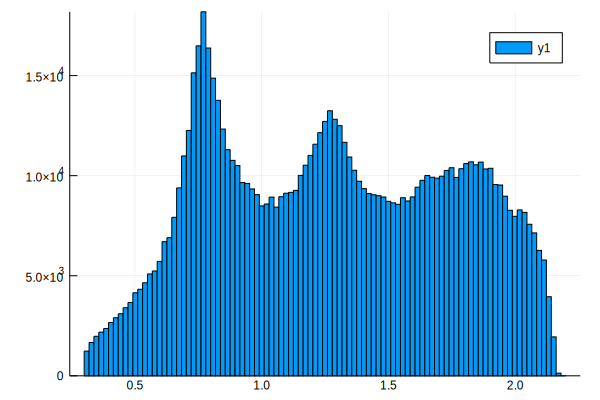

In [53]:
histogram(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights), bins=(linspace(0.3,2.2,100)))

In [55]:
const DT1 = readdlm(joinpath(ENV["HOME"],"cernbox","tmp","pwa_from_scratch_data","2300.rd.txt"));
# const DT1 = readdlm(ENV["HOME"]*"/cernbox/tmp/pwa_from_scratch_data/2300.rd.txt");

In [56]:
@time const DT3 = hcat([swap_kin_parameters(DT1[e,:]) for e in 1:size(DT1,1)]...)';

  0.690665 seconds (5.53 M allocations: 184.259 MiB, 10.45% gc time)


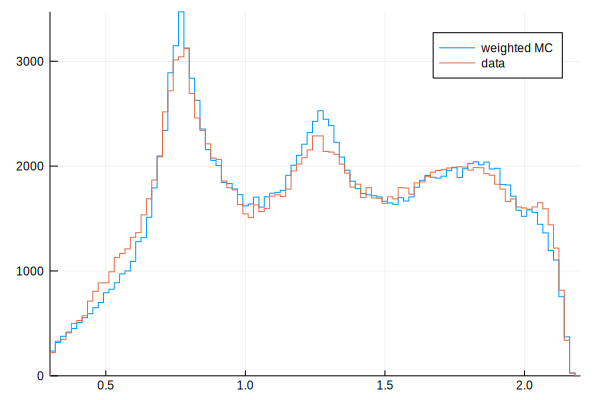

In [57]:
stephist(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(0.3,2.2,100),lab="weighted MC")
stephist!(sqrt.(vcat(DT1[:,2],DT3[:,2])), bins=linspace(0.3,2.2,100),lab="data") 

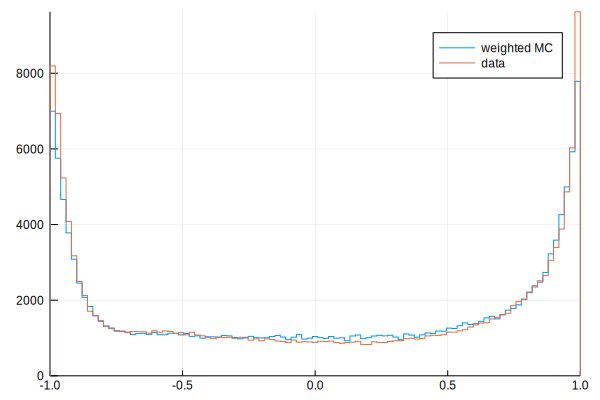

In [58]:
stephist(vcat(MC1[:,3],MC3[:,3]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-1,1,100),lab="weighted MC")
stephist!(vcat(DT1[:,3],DT3[:,3]), bins=linspace(-1,1,100),lab="data") 

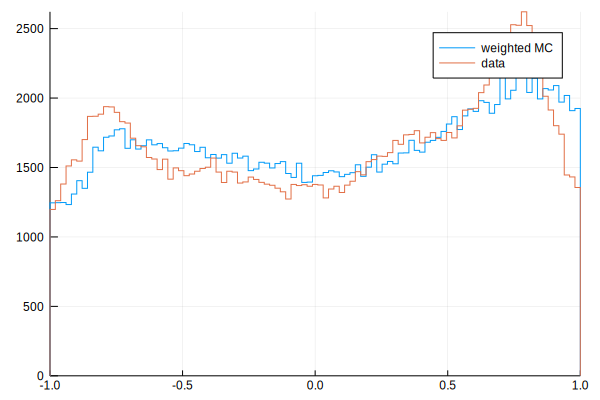

In [59]:
stephist(vcat(MC1[:,5],MC3[:,5]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-1,1,100),lab="weighted MC")
stephist!(vcat(DT1[:,5],DT3[:,5]), bins=linspace(-1,1,100),lab="data") 

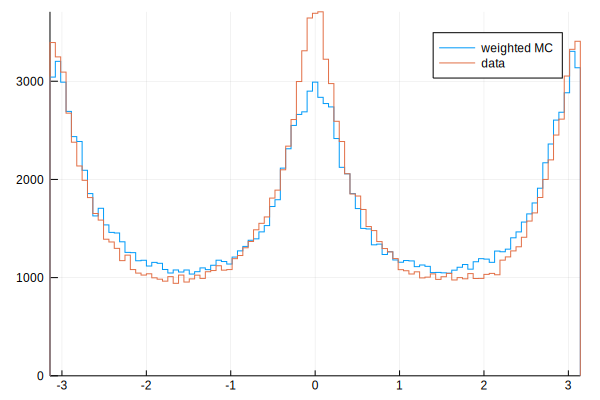

In [60]:
stephist(vcat(MC1[:,6],MC3[:,6]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-π,π,100),lab="weighted MC")
stephist!(vcat(DT1[:,6],DT3[:,6]), bins=linspace(-π,π,100),lab="data") 

### Plot individual components

In [61]:
isobars = [[w==p for w in waves[:,7]] for p in -2:3];

In [62]:
@time weightsI = let mpars = TT*minpars
    [[COHsq(PsiMC[i,:].*mpars.*isobars[p]) for i in 1:size(PsiMC,1)] for p in 1:size(isobars,1)];
end;
# 156.237099 seconds (178.42 M allocations: 16.042 GiB, 1.55% gc time)

156.237099 seconds (178.42 M allocations: 16.042 GiB, 1.55% gc time)


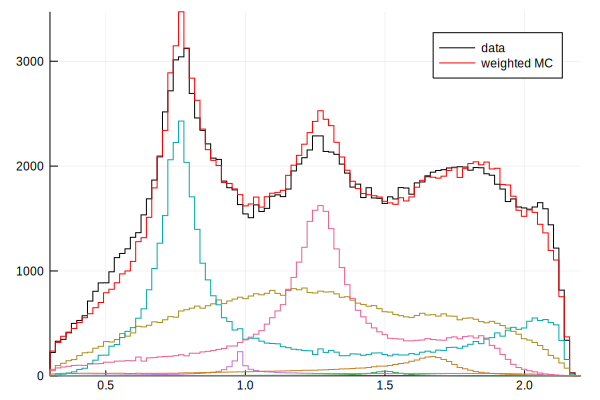

In [63]:
stephist(sqrt.(vcat(DT1[:,2],DT3[:,2])), bins=linspace(0.3,2.2,100),lab="data",lc=:black) 
stephist!(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(0.3,2.2,100),lab="weighted MC",lc=:red)
for p in 1:size(isobars,1)
    stephist!(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weightsI[p],weightsI[p])/size(MC1,1)*size(DT1,1),
        bins=linspace(0.3,2.2,100),lab="")
end
plot!()